In [1]:
import pickle, pickledb
import numpy as np
from itertools import count
from collections import defaultdict
import tensorflow as tf
import tensorflow_hub as hub

train_file = "/data/Vivek/original/HypeNET/dataset/custom_train_0.0_0.05.tsv"
test_file =  "/data/Vivek/original/HypeNET/dataset/custom_test_0.0_0.05.tsv"
instances_file = '../files/dataset/test_instances.tsv'
knocked_file = '../files/dataset/test_knocked.tsv'

NULL_PATH = ((0, 0, 0, 0),)
relations = ["hypernym", "hyponym", "concept", "instance", "none"]
NUM_RELATIONS = len(relations)
prefix = "../junk/db_files/"

USE_link = "https://tfhub.dev/google/universal-sentence-encoder-large/5?tf-hub-format=compressed"
model = hub.load(USE_link)

f = open("../junk/resolved_use.pkl", "rb")
resolved = pickle.load(f)

def extractUSEEmbeddings(words):
    word_embeddings = model(words)
    return word_embeddings.numpy()

In [2]:
arrow_heads = {">": "up", "<":"down"}

def to_list(seq):
    for item in seq:
        if isinstance(item, tuple):
            yield list(to_list(item))
        elif isinstance(item, list):
            yield [list(to_list(elem)) for elem in item]
        else:
            yield item

def extract_direction(edge):

    if edge[0] == ">" or edge[0] == "<":
        direction = "start_" + arrow_heads[edge[0]]
        edge = edge[1:]
    elif edge[-1] == ">" or edge[-1] == "<":
        direction = "end_" + arrow_heads[edge[-1]]
        edge = edge[:-1]
    else:
        direction = ' '
    return direction, edge

def parse_path(path):
    parsed_path = []
    for edge in path.split("*##*"):
        direction, edge = extract_direction(edge)
        if edge.split("/"):
            try:
                embedding, pos, dependency = tuple([a[::-1] for a in edge[::-1].split("/",2)][::-1])
            except:
                print (edge, path)
                raise
            emb_idx, pos_idx, dep_idx, dir_idx = emb_indexer[embedding], pos_indexer[pos], dep_indexer[dependency], dir_indexer[direction]
            parsed_path.append(tuple([emb_idx, pos_idx, dep_idx, dir_idx]))
        else:
            return None
    return tuple(parsed_path)

def parse_tuple(tup):
    x, y = [entity_to_id(word2id_db, elem) for elem in tup]
    paths_x, paths_y = list(extract_paths(relations_db,x,y).items()), list(extract_paths(relations_db,y,x).items())
    path_count_dict_x = { id_to_path(id2path_db, path).replace("X/", tup[0]+"/").replace("Y/", tup[1]+"/") : freq for (path, freq) in paths_x }
    path_count_dict_y = { id_to_path(id2path_db, path).replace("Y/", tup[0]+"/").replace("X/", tup[1]+"/") : freq for (path, freq) in paths_y }
    path_count_dict = {**path_count_dict_x, **path_count_dict_y}
    return path_count_dict

def parse_dataset(dataset):
    parsed_dicts = [parse_tuple(tup) for tup in dataset.keys()]
    parsed_dicts = [{ parse_path(path) : path_count_dict[path] for path in path_count_dict } for path_count_dict in parsed_dicts]
    paths = [{ path : path_count_dict[path] for path in path_count_dict if path} for path_count_dict in parsed_dicts]
    paths = [{NULL_PATH: 1} if not path_list else path_list for i, path_list in enumerate(paths)]
    counts = [list(path_dict.values()) for path_dict in paths]
    paths = [list(path_dict.keys()) for path_dict in paths]
    targets = [rel_indexer[relation] for relation in dataset.values()]
    return list(to_list(paths)), counts, targets



def id_to_entity(db, entity_id):
    entity = db[str(entity_id)]
    return entity

def id_to_path(db, entity_id):
    entity = db[str(entity_id)]
    entity = "/".join(["*##*".join(e.split("_", 1)) for e in entity.split("/")])
    return entity

def entity_to_id(db, entity):
    global success, failed
    entity_id = db.get(entity)
    if entity_id:
        success.append(entity)
        return int(entity_id)
    closest_entity = resolved.get(entity, "")
    if closest_entity and closest_entity[0] and float(closest_entity[1]) > threshold:
        success.append(entity)
        return int(db[closest_entity[0]])
    failed.append(entity)
    return -1

def extract_paths(db, x, y):
    key = (str(x) + '###' + str(y))
    try:
        relation = db[key]
        return {int(path_count.split(":")[0]): int(path_count.split(":")[1]) for path_count in relation.split(",")}
    except Exception as e:
        return {}

word2id_db = pickledb.load(prefix + "w2i.db", False)
id2word_db = pickledb.load(prefix + "i2w.db", False)
path2id_db = pickledb.load(prefix + "p2i.db", False)
id2path_db = pickledb.load(prefix + "i2p.db", False)
relations_db = pickledb.load(prefix + "relations.db", False)


In [28]:

thresholds = [0.5, 0.59, 0.6, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

for threshold in thresholds:
    
    failed, success = [], []

    emb_indexer, pos_indexer, dep_indexer, dir_indexer = [defaultdict(count(0).__next__) for i in range(4)]
    unk_emb, unk_pos, unk_dep, unk_dir = emb_indexer["<UNK>"], pos_indexer["<UNK>"], dep_indexer["<UNK>"], dir_indexer["<UNK>"]
    rel_indexer = {key: idx for (idx,key) in enumerate(relations)}

    train_dataset = {tuple(l.split("\t")[:2]): l.split("\t")[2] for l in open(train_file).read().split("\n")}
    test_dataset = {tuple(l.split("\t")[:2]): l.split("\t")[2] for l in open(test_file).read().split("\n")}
    test_instances = {tuple(l.split("\t")[:2]): l.split("\t")[2] for l in open(instances_file).read().split("\n")}
    test_knocked = {tuple(l.split("\t")[:2]): l.split("\t")[2] for l in open(knocked_file).read().split("\n")}

    paths_train, counts_train, targets_train = parse_dataset(train_dataset)
    paths_test, counts_test, targets_test  = parse_dataset(test_dataset)
    paths_instances, counts_instances, targets_instances  = parse_dataset(test_instances)
    paths_knocked, counts_knocked, targets_knocked  = parse_dataset(test_knocked)

    nodes_train = [[emb_indexer[tup[0]], emb_indexer[tup[1]]] for tup in train_dataset]
    nodes_test = [[emb_indexer[tup[0]], emb_indexer[tup[1]]] for tup in test_dataset]
    nodes_instances = [[emb_indexer[tup[0]], emb_indexer[tup[1]]] for tup in test_instances]
    nodes_knocked = [[emb_indexer[tup[0]], emb_indexer[tup[1]]] for tup in test_knocked]

    print ("Train len: {}, Test len: {}, Instance len: {}, Knocked len: {}".format(len(paths_train), len(paths_test),  len(paths_instances), len(paths_knocked)))
    print (len(failed), len(success))
    emb_indexer_inv = {emb_indexer[key]: key for key in emb_indexer}
    embeds = extractUSEEmbeddings(list(emb_indexer.keys())[1:])
    emb_vals = np.array(np.zeros((1, embeds.shape[1])).tolist() + embeds.tolist())


    output_file = "../Input/data_use_" + str(threshold) + ".pkl"
    f = open(output_file, "wb+")
    pickle.dump([nodes_train, paths_train, counts_train, targets_train, 
                 nodes_test, paths_test, counts_test, targets_test,
                 nodes_instances, paths_instances, counts_instances, targets_instances,
                 nodes_knocked, paths_knocked, counts_knocked, targets_knocked,
                 emb_indexer, emb_indexer_inv, emb_vals, 
                 pos_indexer, dep_indexer, dir_indexer, rel_indexer], f)
    f.close()



Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
0 35498
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
126 35372
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
153 35345
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
605 34893
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
772 34726
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
941 34557
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
1102 34396
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
1357 34141
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
1596 33902
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
1816 33682
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
2062 33436
Train len: 10739, Test len: 1197, Instance len: 275, Knocked len: 5538
2322 33176
Train len: 10739, Test l

In [92]:
counts_padded = np.array([elem + [0 for i in range(max_paths - len(elem))] for elem in counts_train][:100])

In [25]:
scores = [elem[1] for elem in resolved.values()]
counts_dict = {float(str(key)[:4]): 0 for key in np.arange(0.47, 1.01, 0.01)}
for elem in scores:
    counts_dict[float(str(elem)[:4])] += 1
counts_dict.keys()

dict_keys([0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

In [26]:
thresholds = [0.5, 0.59, 0.6, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
len(thresholds)

39

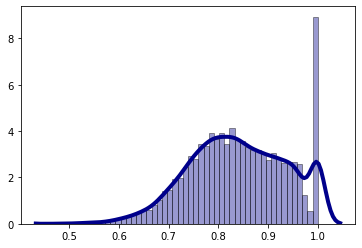

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(sorted(scores), hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [123]:
rel_indexer

{'hypernym': 0, 'hyponym': 1, 'concept': 2, 'instance': 3, 'none': 4}

In [121]:
paths_output[15][:6]

tensor([[[ 0.8237, -0.3493],
         [ 0.2487, -0.9980],
         [ 1.7283, -0.3358],
         ...,
         [ 0.5942, -0.1741],
         [-0.9849,  1.0004],
         [-0.2682,  1.6092]],

        [[-0.7238, -0.1685],
         [-0.5104, -1.3679],
         [ 0.5790,  0.3465],
         ...,
         [ 0.5371, -0.9790],
         [-0.8587, -0.3445],
         [-0.2285,  0.9683]],

        [[ 0.7231,  0.0178],
         [ 1.4549, -1.0254],
         [ 1.3443,  0.2672],
         ...,
         [-0.5941,  0.8811],
         [ 0.0183, -0.7739],
         [ 1.1137, -0.2095]],

        [[-0.5445,  0.8521],
         [-1.0216,  0.4876],
         [-0.2075,  0.6121],
         ...,
         [ 0.0787, -1.2297],
         [ 0.2751, -0.0413],
         [ 0.2628,  0.9497]],

        [[-3.2454,  0.8706],
         [ 1.8683,  0.2403],
         [-1.9614,  1.6072],
         ...,
         [ 1.5648,  0.6847],
         [-0.3047, -0.4647],
         [ 0.0309,  0.7784]],

        [[-0.6388, -0.7616],
         [-0.7573,  0

In [117]:
counts_train[:100].index([1, 2, 1, 1, 1, 1])

15